# 1. Skip-gram with naiive softmax 

I recommend you take a look at these material first.

* http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [2]:
print(torch.__version__)
print(nltk.__version__)

1.0.0
3.4


In [3]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
# torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch


In [5]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))

## Data load and Preprocessing 

### Load corpus : Gutenberg corpus

If you don't have gutenberg corpus, you can download it first using nltk.download()

In [6]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [7]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:100] # sampling sentences for test
corpus = [[word.lower() for word in sent] for sent in corpus]

### Extract Stopwords from unigram distribution's tails

In [8]:
word_count = Counter(flatten(corpus))
border = int(len(word_count) * 0.01) 

In [9]:
stopwords = word_count.most_common()[:border] + list(reversed(word_count.most_common()))[:border]

In [10]:
stopwords = [s[0] for s in stopwords]

In [11]:
stopwords

[',', '.', 'the', 'of', 'and', 'man', 'artificial', 'civitas', '--(', 'state']

### Build vocab

In [12]:
vocab = list(set(flatten(corpus)) - set(stopwords))
vocab.append('<UNK>')

In [13]:
print(len(set(flatten(corpus))), len(vocab))

592 583


In [14]:
word2index = {'<UNK>' : 0} 

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v:k for k, v in word2index.items()} 

### Prepare train data 

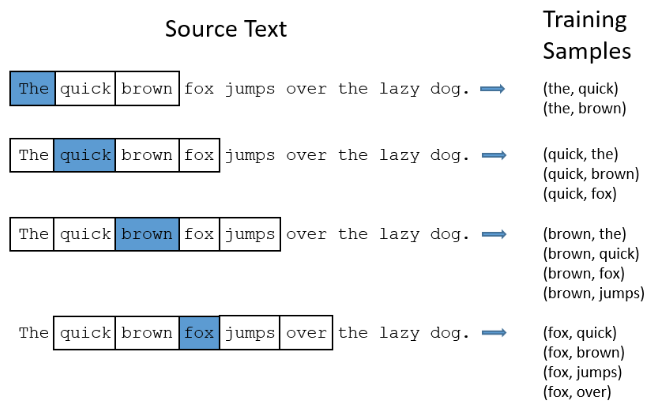

In [15]:
# window data example
# borrowed image from http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
from IPython.display import Image
Image(filename='../images/01.skipgram-prepare-data.png')

In [16]:
WINDOW_SIZE = 3
windows = flatten([list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in corpus])

In [17]:
windows[0]

('<DUMMY>', '<DUMMY>', '<DUMMY>', '[', 'moby', 'dick', 'by')

In [18]:
train_data = []

for window in windows:
    for i in range(WINDOW_SIZE * 2 + 1):
        if i == WINDOW_SIZE or window[i] == '<DUMMY>': 
            continue
        train_data.append((window[WINDOW_SIZE], window[i]))

print(train_data[:WINDOW_SIZE * 2])

[('[', 'moby'), ('[', 'dick'), ('[', 'by'), ('moby', '['), ('moby', 'dick'), ('moby', 'by')]


In [19]:
X_p = []
y_p = []

In [20]:
train_data[0]

('[', 'moby')

In [21]:
for tr in train_data:
    X_p.append(prepare_word(tr[0], word2index).view(1, -1))
    y_p.append(prepare_word(tr[1], word2index).view(1, -1))

In [22]:
train_data = list(zip(X_p, y_p))

In [23]:
len(train_data)

7606

## Modeling

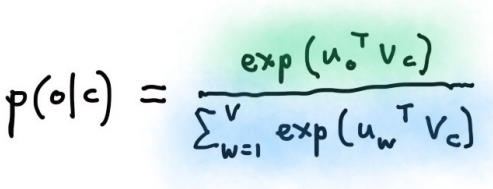

In [24]:
# borrowed image from http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture2.pdf
from IPython.display import Image
Image(filename='../images/01.skipgram-objective.png')

In [25]:
class Skipgram(nn.Module):
    def __init__(self, vocab_size, projection_dim):
        super(Skipgram, self).__init__()
        # 输入层和输出层有各自的embedding矩阵，在某些情况下可以复用
        self.embedding_v = nn.Embedding(vocab_size, projection_dim)
        self.embedding_u = nn.Embedding(vocab_size, projection_dim)

        self.embedding_v.weight.data.uniform_(-1, 1)  # init
        self.embedding_u.weight.data.uniform_(0, 0)  # init
        #self.out = nn.Linear(projection_dim,vocab_size)

    def forward(self, center_words, target_words, outer_words):
        center_embeds = self.embedding_v(center_words)  # B x 1 x D
        target_embeds = self.embedding_u(target_words)  # B x 1 x D
        outer_embeds = self.embedding_u(outer_words)  # B x V x D

        # Bx1xD * BxDx1 => Bx1
        scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        # BxVxD * BxDx1 => BxV
        norm_scores = outer_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)  
        # log-softmax
        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1)))  
        return nll  # negative log likelihood

    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        return embeds

In [33]:
# class Skipgram1(nn.Module):

#     def __init__(self, vocab_size, projection_dim):
#         super(Skipgram1, self).__init__()
#         self.embedding_v = nn.Embedding(vocab_size, projection_dim)
#         self.embedding_v.weight.data.uniform_(-1, 1)  # init

#     def forward(self, center_words, target_words, outer_words):
#         center_embeds = self.embedding_v(center_words)  # B x 1 x D
#         target_embeds = self.embedding_v(target_words)  # B x 1 x D
#         outer_embeds = self.embedding_v(outer_words)  # B x V x D

#         # Bx1xD * BxDx1 => Bx1
#         scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
#         # BxVxD * BxDx1 => BxV
#         norm_scores = outer_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)  
#         # log-softmax
#         nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1)))  
#         return nll  # negative log likelihood

#     def prediction(self, inputs):
#         embeds = self.embedding_v(inputs)
#         return embeds

## Train  

In [34]:
EMBEDDING_SIZE = 30
BATCH_SIZE = 256
EPOCH = 100

In [35]:
losses = []
model = Skipgram(len(word2index), EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(EPOCH):
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
        inputs, targets = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        vocabs = prepare_sequence(list(vocab), word2index).expand(inputs.size(0), len(vocab))  # B x V
        model.zero_grad()

        loss = model(inputs, targets, vocabs)
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 10 == 0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch,np.mean(losses)))
        losses = []

Epoch : 0, mean_loss : 8.16
Epoch : 10, mean_loss : 5.22
Epoch : 20, mean_loss : 4.25
Epoch : 30, mean_loss : 4.07
Epoch : 40, mean_loss : 3.99
Epoch : 50, mean_loss : 3.95


## Test

In [37]:
def word_similarity(target, vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target, word2index))
    else:
        target_V = model.prediction(prepare_word(target, word2index))
    similarities = []
    for i in range(len(vocab)):
        if vocab[i] == target: continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        cosine_sim = F.cosine_similarity(target_V, vector).data.tolist()[0] 
        similarities.append([vocab[i], cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10] # sort by similarity

In [40]:
test = random.choice(list(vocab))
test

'known'

In [41]:
word_similarity(test, vocab)

[['mockingly', 0.6789984107017517],
 ['whereas', 0.6469522714614868],
 ['waves', 0.6431313753128052],
 ['generations', 0.636249303817749],
 ['many', 0.6149567365646362],
 ['things', 0.6118574738502502],
 ['nations', 0.6059315800666809],
 ['ibid', 0.5997291803359985],
 ['flags', 0.5995597243309021],
 ['am', 0.5866448283195496]]